In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch, torch.nn as nn, torch.functional as F, torch.utils.data as data, torchnet as tnt
import torchvision, numpy as np, os
import matplotlib.pyplot as plt, fastai
from fastai.conv_learner import ConvnetBuilder
from fastai.model import resnext50, resnet34
from fastai.dataset import BaseDataset
import nvvl, time
import sys, os
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [3]:
#Adding layer.freeze and layer.unfreeze capability to nn.Module layers

def freeze(self):
    for param in self.parameters(): param.requires_grad=False
def unfreeze(self):
    for param in self.parameters(): param.requires_grad=True

nn.Module.freeze=freeze
nn.Module.unfreeze=unfreeze

In [4]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); device

device(type='cuda', index=0)

In [5]:
PATH="/home/sufiyan/Common_data/mtp2/dataset/OLD/100_vids/"
PATH_L_Vids=PATH+"LEFT/"
PATH_L=PATH+"LEFT_data/"
PATH_L_L=PATH+"LEFT_labels/"
PATH_R_Vids=PATH+"RIGHT/"
PATH_R=PATH+"RIGHT_data/"
PATH_R_L=PATH+"RIGHT_labels/"

In [6]:
#string_to_int and int_to_string mapping
stoi={"w":0, "a":1, "d":2}; itos={0:"Clear", 1:"Left", 2:"Right"}

In [7]:
leftVids =[PATH_L_Vids+fileName for fileName in os.listdir(PATH_L_Vids) if os.path.isfile(PATH_L_Vids+fileName)]
rightVids=[PATH_R_Vids+fileName for fileName in os.listdir(PATH_R_Vids) if os.path.isfile(PATH_R_Vids+fileName)]

In [8]:
def get_label(fileName, frame_num, _=None):
        vidName=fileName.split("/")[-1]
        labelName=".".join(vidName.split(".")[:-1]+["npy"])
        if fileName.split("/")[-2]=="RIGHT_data":
            labels=list(np.load(PATH_R_L+labelName))
        elif fileName.split("/")[-2]=="LEFT_data":
            labels=list(np.load(PATH_L_L+labelName))
        else: raise ValueError(f"Passed videoFile {fileName} has non recognizable parent folder")
        try: return stoi[labels[frame_num]]
        except: return stoi[labels[-1]]

In [9]:
trainDataset=nvvl.VideoDataset(leftVids[:-5]+rightVids[:-5], sequence_length=1, get_label=get_label)

In [10]:
validDataset=nvvl.VideoDataset(leftVids[-5:]+rightVids[-5:], sequence_length=1, get_label=get_label)

In [9]:
class frameSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, fps=3):
        self.fps=fps
        self.data_source = data_source
        
    def __iter__(self):
        samples=[num for num in self.data_source if (num%(self.fps+np.random.randint(-2,3))==0)] 
        np.random.shuffle(samples)
        return iter(samples)

    def __len__(self):
        return len(self.data_source)    

In [12]:
trainLoader=nvvl.VideoLoader(trainDataset, batch_size=200, sampler=frameSampler(range(len(trainDataset))), buffer_length=1)
validLoader=nvvl.VideoLoader(validDataset, batch_size=200, sampler=frameSampler(range(len(validDataset))), buffer_length=1)

In [13]:
modelData=fastai.dataset.ModelData("./tmp", trainLoader, validLoader)

In [14]:
model=ConvnetBuilder(resnet34, c=3, is_multi=False, is_reg=False, pretrained=True)
loss=nn.CrossEntropyLoss
optim=torch.optim.Adam

In [15]:
learner=fastai.learner.Learner(modelData, model, optim, metrics=[accuracy_score])

In [16]:
learner.fit(0.001, 5)

  0%|          | 0/273 [00:00<?, ?it/s]


RuntimeError: Need to exhaust iterator before creating a new one

In [10]:
class oneVidDataset(BaseDataset):
    def __init__(self, fileName, get_label=None):
        self.fileName=fileName
        self.get_label=get_label
    
    def __getitem__(self,idx):
        #skipping the first and last 125 frames.
        idx+=125
        x=np.load(self.fileName)[idx]
        x=np.squeeze(x)     #extra 1 dimention removed if any
        if len(x.shape)==2 : x=np.dstack((x,x,x)) #id image is 1 channel, make it 3 channel
        x=np.rollaxis(x, 2)   #Make the images channel first
        x=x[:,:224,:224].astype("float32")
        return (x, self.get_label(self.fileName, idx))
    
    def __len__(self):
        return len(np.load(self.fileName))-250 #skiping first and last 125 frames

In [11]:
def getConcatDataset(fileNames):
    datasets=[oneVidDataset(fileName, get_label=get_label) for fileName in fileNames]
    return torch.utils.data.ConcatDataset(datasets)

In [12]:
leftVids =[PATH_L+fileName for fileName in os.listdir(PATH_L) if os.path.isfile(PATH_L+fileName)]
rightVids=[PATH_R+fileName for fileName in os.listdir(PATH_R) if os.path.isfile(PATH_R+fileName)]

In [13]:
trainDataset=getConcatDataset(leftVids[:55]+rightVids[:55])
validDataset=getConcatDataset(leftVids[55:]+rightVids[55:])

In [14]:
len(trainDataset)

25918

In [15]:
trainLoader=torch.utils.data.DataLoader(trainDataset, batch_size=170, sampler=frameSampler(range(len(trainDataset))), drop_last=True)
validLoader=torch.utils.data.DataLoader(validDataset, batch_size=170, sampler=frameSampler(range(len(validDataset))), drop_last=True)

In [16]:
modelData=fastai.dataset.ModelData(path=".", trn_dl=trainLoader, val_dl=validLoader)

In [17]:
model=ConvnetBuilder(resnet34, c=3, is_multi=False, is_reg=False, pretrained=True)
[layer.freeze() for i,layer in enumerate(model.model.children()) if i>11]
learner=fastai.learner.Learner(modelData, model, opt_fn=torch.optim.Adam, models_name="First_Model", crit=torch.nn.CrossEntropyLoss())

In [18]:
#Learnable Layers
for i, layer in enumerate(learner.model.children()):
    for param in  layer.parameters():
        if param.requires_grad==True:
            print(layer)
            break

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2)

In [20]:
learner.lr_find(start_lr=1e-3)

 19%|█▊        | 99/534 [01:26<06:18,  1.15it/s, loss=6.9] 

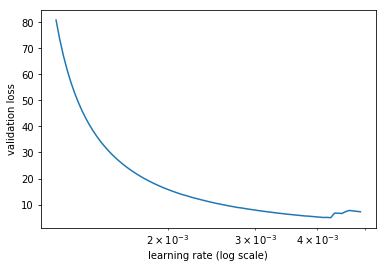

In [21]:
learner.sched.plot()

In [19]:
def accuracy(y, y_pred):
    s=nn.Softmax()
    pred=s(y_pred)
    pred=F.argmax(pred, dim=1)
    score=(y.cpu().numpy()==pred.cpu().numpy())
    score=sum(score)/len(y.cpu().numpy())
    return score

In [18]:
learner.fit(1e-4, n_cycle=5)
learner.fit(1e-4, n_cycle=3, cycle_mult=2)
learner.fit(1e-4, n_cycle=5)
learner.save("firstModel_resnet34_after_17_epochs")

epoch      trn_loss   val_loss                             
    0      1.194328   0.521554  
    1      0.634351   0.678225                              
    2      0.465098   0.937977                              
    3      0.382337   0.73261                               
    4      0.289743   1.329113                              



epoch      trn_loss   val_loss                              
    0      0.249873   1.030871  
    1      0.178758   1.311914                              
    2      0.137881   1.567078                              
    3      0.120109   1.420493                              
    4      0.089631   1.304374                               
    5      0.070393   1.641189                               
    6      0.063905   1.85725                                



epoch      trn_loss   val_loss                               
    0      0.063146   1.514781  
    1      0.057519   2.372115                               
    2      0.050836   1.987937                               
    3      0.049565   1.563692                               
    4      0.050297   2.113982                               



[2.1139818827311196]

In [19]:
learner.load("firstModel_resnet34_after_17_epochs")

In [21]:
for x,y in validLoader:
    x=x.to(device)
    y=y.to(device)
    pred=(learner.model(x))
    print(accuracy(y, pred))
    break

RuntimeError: CUDA error: out of memory

In [20]:
5//2

2